In [1]:
import numpy as np
import pandas as pd
print pd.__version__

0.19.1


In [2]:
data_dir = "data/pdaid/"
!ls $data_dir

bacterial.csv          neural_predictions.csv viral.csv
fungal.csv             parasitic.csv


In [3]:
amino_acids = {"A": "Alanine",
            "C": "Cysteine",
            "D": "Aspartic Acid",
            "E": "Glutamic Acid",
            "F": "Phenylalanine",
            "G": "Glycine",
            "H": "Histidine",
            "I": "Isoleucine",
            "K": "Lysine",
            "L": "Leucine",
            "M": "Methionine",
            "N": "Asparagine",
            "P": "Proline",
            "Q": "Glutamine",
            "R": "Arginine",
            "S": "Serine",
            "T": "Threonine",
            "U": "Selenocysteine",
            "V": "Valine",
            "W": "Tryptophan",
            "Y": "Tyrosine"}

In [4]:
seq_len = 9    

def data_cleanup(group, group_name):
    group["disease"] = group_name
    group.columns = [
        'type', 'epitope_sequence', 'start', 'end', 'chebi', 'syn', 'protein',
        'protein_id', 'organism', 'oid', 'comments', 'disease'
    ]
    # Remove entries with '+' notation (note: looking into this, e.g. "PLNISLGDVVLY + DEAM(N3)")
    group = group[group.epitope_sequence.str.find('+') == -1]
    # Remove epitopes less than 'seq_len' AAs long
    group = group[group.epitope_sequence.str.len() >= seq_len]
    # Use 'seq_len' AAs from the C-terminus
    group['epitope_sequence'] = group.epitope_sequence.str[-seq_len::]
    group = group[["epitope_sequence", "disease"]]
    group = group[group.epitope_sequence.str.find("Z") == -1]
    group = group[group.duplicated(subset=["epitope_sequence"], keep=False) == False]
    group = group.sample(frac=1).head(3400)
    return group

disease_groups = ["bacterial", "parasitic", "viral", "fungal"]
disease_col = "disease"
bacterial = data_cleanup(pd.DataFrame.from_csv(data_dir + "bacterial.csv"), "bacterial")
fungal = data_cleanup(pd.DataFrame.from_csv(data_dir + "fungal.csv"), "fungal")
parasitic = data_cleanup(pd.DataFrame.from_csv(data_dir + "parasitic.csv"), "parasitic")
viral = data_cleanup(pd.DataFrame.from_csv(data_dir + "viral.csv"), "viral")

    
print "Input -- Bacterial: %d, Fungal: %d, Parasitic: %d, Viral: %d" % \
    (bacterial.shape[0], fungal.shape[0], parasitic.shape[0], viral.shape[0])

# Consider putting fungal back in? (only 39 samples)
all_samples = bacterial\
    .append(parasitic, ignore_index=True)\
    .append(viral, ignore_index= True)
    
print "All filtered samples: %d" % (all_samples.shape[0])

Input -- Bacterial: 2687, Fungal: 21, Parasitic: 2318, Viral: 3400
All filtered samples: 8405


In [5]:
from aa_props import seq_to_aa_props
from sklearn.preprocessing import MinMaxScaler
import random

y = []
X = []

for (rowid, seq, disease) in all_samples.itertuples():
    valid = True
    for aa in seq:
        if not aa in amino_acids.keys():
            valid = False
            break
    if valid:
        features = seq_to_aa_props(seq)
        X.append(features)
        y.append(disease)

# Scale the data
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

ll_training_filename = "/tmp/pdaid_training.ll"
ll_testing_filename = "/tmp/pdaid_testing.ll"

with open(ll_training_filename, 'w') as ll_train:
    with open(ll_testing_filename, 'w') as ll_test:
        for (features, disease) in zip(scaled_X, y):
            if random.random() >= 0.75:
                ll_file = ll_test
            else:
                ll_file = ll_train
            ll_file.write("%d" % (disease_groups.index(disease)))
            for (i, feature) in enumerate(features):
                ll_file.write(" %d:%.12f" % (i+1, feature))
            ll_file.write("\n")

In [6]:
# Find the best C parameter for the LR model
LR_findC = !train -C -s 0 "$ll_training_filename"
print "\n".join(LR_findC)

Doing parameter search with 5-fold cross validation.
log2c= -21.00	rate=40.4659
log2c= -20.00	rate=40.4659
log2c= -19.00	rate=40.4659
log2c= -18.00	rate=40.4659
log2c= -17.00	rate=40.4659
log2c= -16.00	rate=40.4659
log2c= -15.00	rate=40.4659
log2c= -14.00	rate=42.285
log2c= -13.00	rate=44.9338
log2c= -12.00	rate=48.0772
log2c= -11.00	rate=49.6569
log2c= -10.00	rate=51.5558
log2c=  -9.00	rate=52.2738
log2c=  -8.00	rate=52.8163
log2c=  -7.00	rate=53.2472
log2c=  -6.00	rate=54.1407
log2c=  -5.00	rate=54.3801
log2c=  -4.00	rate=54.396
log2c=  -3.00	rate=54.6354
log2c=  -2.00	rate=54.9067
log2c=  -1.00	rate=54.5397
log2c=   0.00	rate=54.4918
log2c=   1.00	rate=54.4918
log2c=   2.00	rate=54.2684
log2c=   3.00	rate=54.2684
log2c=   4.00	rate=54.2684
log2c=   5.00	rate=54.2684
Best C = 0.25  CV accuracy = 54.9067%


In [7]:
# Find the best C parameter for the SVC model
SVC_findC = !train -C -s 2 "$ll_training_filename"
print "\n".join(SVC_findC)

Doing parameter search with 5-fold cross validation.
log2c= -22.00	rate=40.4659
log2c= -21.00	rate=40.4659
log2c= -20.00	rate=40.4659
log2c= -19.00	rate=40.4659
log2c= -18.00	rate=40.4659
log2c= -17.00	rate=42.7477
log2c= -16.00	rate=45.4284
log2c= -15.00	rate=48.5878
log2c= -14.00	rate=49.9282
log2c= -13.00	rate=51.9228
log2c= -12.00	rate=52.3855
log2c= -11.00	rate=53.0716
log2c= -10.00	rate=53.694
log2c=  -9.00	rate=54.396
log2c=  -8.00	rate=54.3003
log2c=  -7.00	rate=54.396
log2c=  -6.00	rate=54.4758
log2c=  -5.00	rate=54.5077
log2c=  -4.00	rate=54.5077
log2c=  -3.00	rate=54.5556
log2c=  -2.00	rate=54.412
log2c=  -1.00	rate=54.412
log2c=   0.00	rate=54.428
log2c=   1.00	rate=54.428
log2c=   2.00	rate=54.428
log2c=   3.00	rate=54.428
log2c=   4.00	rate=54.428
Best C = 0.125  CV accuracy = 54.5556%


In [8]:
def create_model_and_predictions(search_output, solver, model_file, predictions_file, probability_estimates, train_file, test_file):
    # Grab C from the last line...
    bestC = float(search_output[-1].split(" ")[3])
    cmd = "train -c %f -s %d '%s' '%s'" % (bestC, solver, train_file, model_file)
    print "> " + cmd
    createModel = !{cmd}
    print "\n".join(createModel)
    cmd = "predict -b %d '%s' '%s' '%s'" % (probability_estimates, test_file, model_file, predictions_file)
    print "> " + cmd
    predict = !{cmd}
    print "\n".join(predict)
    print "\n"

LR_model_file="/tmp/pdaid_lr.model"
SVC_model_file="/tmp/pdaid_svc.model"
LR_predictions_file = "/tmp/lr.predictions"
SVC_predictions_file = "/tmp/svc.predictions"
    
create_model_and_predictions(LR_findC, 0, LR_model_file, LR_predictions_file, 1, ll_training_filename, ll_testing_filename)
create_model_and_predictions(SVC_findC, 2, SVC_model_file, SVC_predictions_file, 0, ll_training_filename, ll_testing_filename)

> train -c 0.250000 -s 0 '/tmp/pdaid_training.ll' '/tmp/pdaid_lr.model'
iter  1 act 1.097e+02 pre 1.073e+02 delta 7.592e-02 f 1.086e+03 |g| 2.890e+03 CG   1
cg reaches trust region boundary
iter  2 act 1.083e+01 pre 1.075e+01 delta 1.834e-01 f 9.763e+02 |g| 2.043e+02 CG   2
cg reaches trust region boundary
iter  3 act 1.576e+01 pre 1.568e+01 delta 2.626e-01 f 9.655e+02 |g| 2.105e+02 CG   2
cg reaches trust region boundary
iter  4 act 1.111e+01 pre 1.098e+01 delta 4.331e-01 f 9.498e+02 |g| 8.569e+01 CG   2
cg reaches trust region boundary
iter  5 act 9.987e+00 pre 1.008e+01 delta 4.578e-01 f 9.386e+02 |g| 4.402e+01 CG   3
cg reaches trust region boundary
iter  6 act 1.037e+01 pre 1.020e+01 delta 5.371e-01 f 9.287e+02 |g| 6.435e+01 CG   3
cg reaches trust region boundary
iter  7 act 8.174e+00 pre 8.156e+00 delta 7.514e-01 f 9.183e+02 |g| 4.564e+01 CG   4
cg reaches trust region boundary
iter  8 act 6.518e+00 pre 6.443e+00 delta 1.029e+00 f 9.101e+02 |g| 2.804e+01 CG   4
cg reaches trust 

In [9]:
# Simple method to convert from liblinear format to fann format
def convert_liblinear_file(ll_filepath, fann_filepath):
    with open(ll_filepath, 'r') as ll_file:
        data = []
        for line in ll_file.readlines():
            fields = line.strip().split(" ")
            row = [int(fields[0])]
            for (i, field) in enumerate(fields[1:]):
                (colnum, value) = field.split(":")
                assert(int(colnum) == (i + 1))
                row.append(float(value))
            data.append(row)
    with open(fann_filepath, 'w') as fann_file:
        rows = len(data)
        cols = len(data[0]) -1
        fann_file.write("%s %s %s\n" % (rows, cols, 3))
        for row in data:
            disease = row[0]
            disease_vector = [0, 0, 0]
            disease_vector[disease] = 1
            for feature in row[1:]:
                fann_file.write("%.12f " % (feature))
            fann_file.write("\n%s\n" % (" ".join([str(i) for i in disease_vector])))
        
fann_training_file = "/tmp/pdaid_training.fann"
fann_testing_file = "/tmp/pdaid_testing.fann"
convert_liblinear_file(ll_testing_filename, fann_testing_file)
convert_liblinear_file(ll_training_filename, fann_training_file)

In [10]:
from fann2 import libfann

train_data = libfann.training_data()
train_data.read_train_from_file(fann_training_file)

num_input = train_data.num_input_train_data()
num_output = train_data.num_output_train_data()

alpha = 5.0 # Range of 2 to 10, below 5 might cause overfitting
num_hidden = train_data.length_train_data() / (alpha * (num_input  + num_output))
ann = libfann.neural_net()
ann.create_sparse_array(connection_rate=1, layers=(num_input, num_output))
#ann.set_scaling_params(data=train_data, new_input_min=0, new_input_max=1, new_output_min=0, new_output_max=1)
#ann.scale_train(data=train_data)
ann.set_learning_rate(0.7)
#ann.set_train_error_function(libfann.ERRORFUNC_LINEAR)
ann.set_activation_function_hidden(libfann.ELLIOT)
# Steepness= 0.5 ELLIOT AUC=0.88
ann.set_activation_steepness_output(0.5)
ann.set_activation_function_output(libfann.ELLIOT)

neural_network_save_file = "/tmp/pdaid.net"

ann.train_on_data(data=train_data, desired_error=0.1, epochs_between_reports=5, max_epochs=500)
ann.save(neural_network_save_file)
#ann.print_connections()
#ann.print_parameters()

True

In [11]:
from fann2 import libfann

ann = libfann.neural_net()
ann.create_from_file(neural_network_save_file)

test_data = libfann.training_data()
test_data.read_train_from_file(fann_testing_file)
#ann.scale_train(data=test_data)

ann.reset_MSE()
input=test_data.get_input()
output=test_data.get_output()

prediction_file = data_dir + "neural_predictions.csv"
with open(prediction_file, 'w') as predict_file:
    predict_file.write(",actual,predicted,p0,p1,p2\n")
    for i in range(len(input)):
        predict = ann.test(input[i], output[i])
        predicted_disease = predict.index(max(predict))
        predict_file.write("%d,%d,%d, %s\n" % (i, int(output[i].index(1)), predicted_disease, ",".join([str(i) for i in predict]))) 
        # int(output[i][0]), predict[0]))
print "MSE error on test data: %f" % ann.get_MSE()

MSE error on test data: 0.190993


In [12]:
import pandas as pd
from sklearn.metrics import classification_report

df = pd.DataFrame.from_csv(prediction_file)
real = df.actual.astype("int")
predicted = df.predicted

print [a for a in enumerate(disease_groups)]
print classification_report(real, predicted)

[(0, 'bacterial'), (1, 'parasitic'), (2, 'viral'), (3, 'fungal')]
             precision    recall  f1-score   support

          0       0.50      0.38      0.43       718
          1       0.60      0.52      0.56       556
          2       0.53      0.69      0.60       863

avg / total       0.54      0.54      0.53      2137



In [13]:
import numpy as np
import pandas as pd
from math import log

def alphabet_dict():
    d = {}
    for letter in amino_acids.keys():
        d[letter] = 0
    return d

def init_counters():
    return [alphabet_dict() for i in range(seq_len)]

counters = {"bacterial": init_counters(),
            "viral": init_counters(),
            "parasitic": init_counters(),
            "fungal": init_counters(),
            "total": init_counters()}
for (rowid, seq, disease) in all_samples.itertuples():
    for (i, aa) in enumerate(seq):
        counters[disease][i][aa.upper()] += 1

for i in range(seq_len):
    for aa in amino_acids.keys():
        # TODO: readd fungal values?
        counters["total"][i][aa] += (counters["bacterial"][i][aa] \
                                    + counters["viral"][i][aa]\
                                    + counters["parasitic"][i][aa])
    
def prob(disease, pos, aa):
    counter = counters[disease][pos]
    total = 0
    for count in counter.values():
        total += count
    if counter[aa] == 0:
        return 0
    else:
        return float(counter[aa])/total
    
def safe_log(x):
    if x <= 0:
        return float("-inf")
    return log(x, 2.0)

def generate_kl_heatmap(disease):
    result = [alphabet_dict() for i in range(seq_len)]
    for i in range(seq_len):
        for letter in amino_acids.keys():
            result[i][letter] = prob(disease, i, letter) * safe_log( prob(disease, i, letter) / max(0.00000001, prob("total", i, letter)))

    r = pd.DataFrame(result).transpose()
    vmin = r.min().min()
    vmax = r.max().max()
    center = (vmax - vmin)/2

    import seaborn as sns
    sns.set()
    ax = sns.heatmap(r, linewidths=.5,
            yticklabels=["%s (%s)" % (amino_acids[code], code) for code in r.index],
            xticklabels=["%d" %(i) for i in range(seq_len)], 
            vmin=vmin, vmax=vmax, center=center, cmap="YlGnBu", alpha=0.8)
    ax.set_title('%s Kullback-Leibler Information, $I(i) = \sum_{L=0}^{N}p_{i}^{L}\log_2(p_{i}^{L}/q_{i}^{L})$' % (disease))

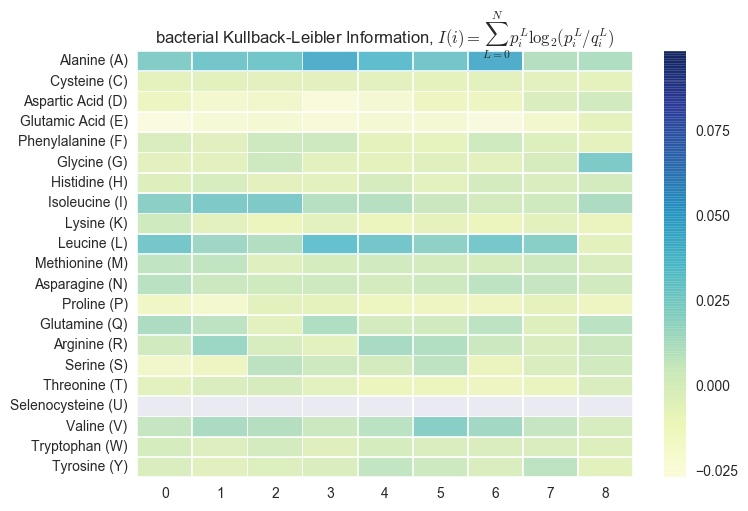

In [14]:
%matplotlib inline
generate_kl_heatmap("bacterial")

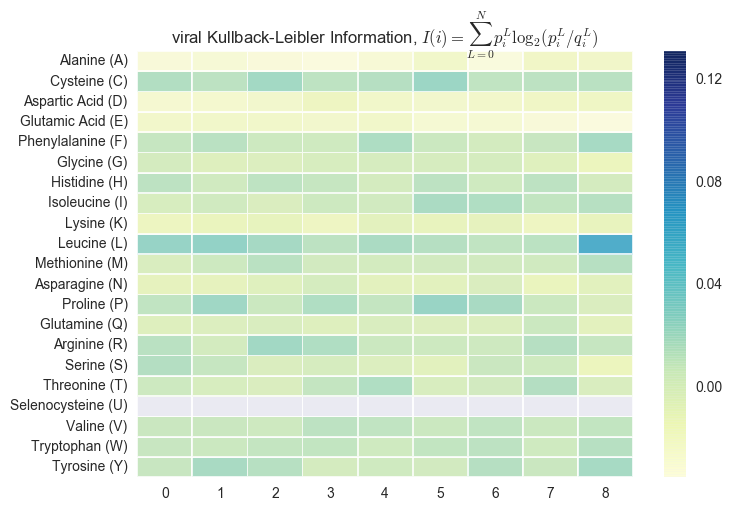

In [15]:
%matplotlib inline
generate_kl_heatmap("viral")

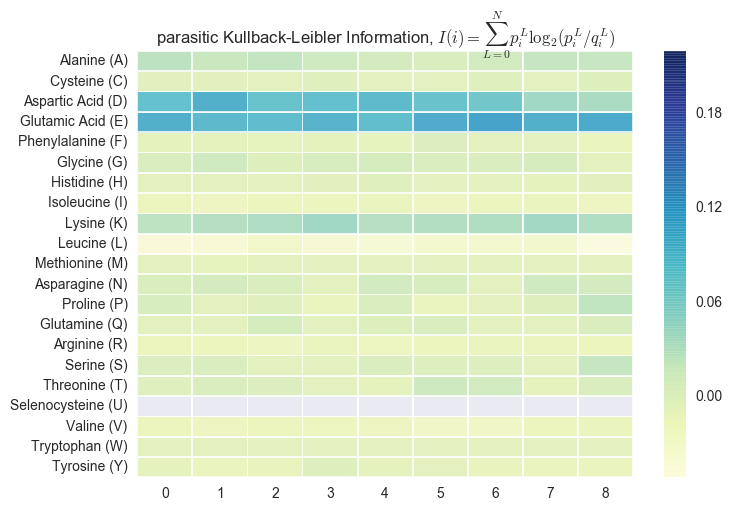

In [16]:
%matplotlib inline
generate_kl_heatmap("parasitic")